# Model Selection

To train a predictive model for the outcome of individual pool matches, we will use the results from ~20,000 NAPA (North American Poolshooter Association) matches played in the last 10 years.

## [Importing and examining data](#import)

## [Linear regression model for prediction match scores](#linear)

## [Logit model for winning probability](#log)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
sns.set_context("talk", font_scale = 1)
style.use('seaborn-whitegrid')

data = pd.read_csv('results_model_data_8.csv')

## Features

All features are recorded in terms of the differences between each player. A positive value indicates that player A has the higher feature score.  

* __Race Margin__: The difference between the number of games required to win the overall match.
* __Win % Margin__: The difference between the historical win percentages of each player.
* __Skill Margin__: The difference between the skill levels of each player.
* __Game Margin__: The difference between the total number of matches each player has played during their membership of NAPA.
* __AvgPPM Margin__: The difference between the average points per match for each player.
* __State__: The state in which the match took place, encoded as a number.
* __Win Margin__: The winning margin (in number of games) for player A in the match (the target variable). Negative values indicate that player B won the match.

In [2]:
df = data[['Race Margin', 'Win % Margin', 'Skill Margin', 'Game Margin', 'AvgPPM Margin', 'State', 'Win Margin']]
df.head()

,Race Margin,Win % Margin,Skill Margin,Game Margin,AvgPPM Margin,State,Win Margin
0,0.0,5.769231,-3,-64,-0.02,0,-3.0
1,-1.0,5.769231,-3,-64,-0.02,0,2.0
2,0.0,-1.388889,6,-69,-0.73,0,4.0
3,0.0,-1.388889,6,-69,-0.73,0,-1.0
4,0.0,2.040816,1,51,-0.42,0,-2.0


## Feature distributions <a id='import'></a>

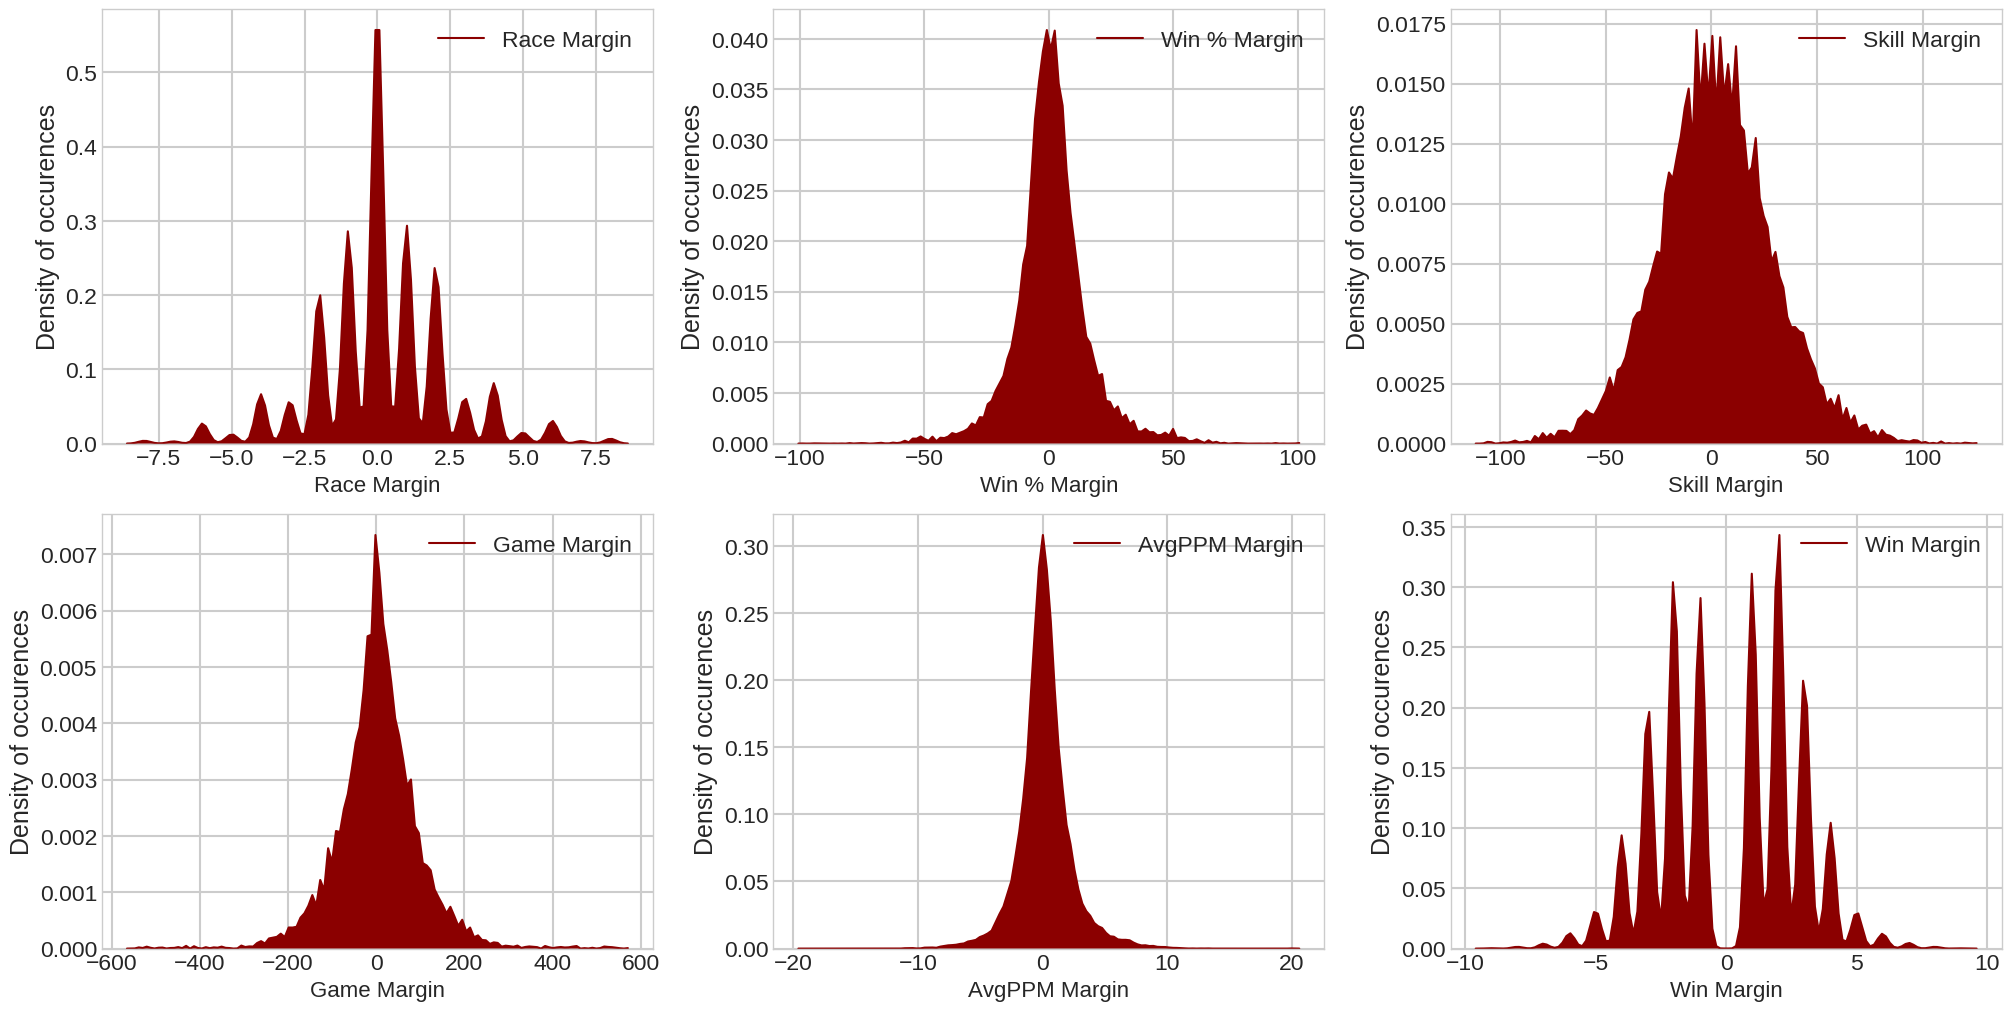

In [3]:
def density_plot(df, col, ax):
    sns.kdeplot(df[col], clip_on=False, shade=True, alpha=1, 
                lw=1.5, bw=0.2, color = 'darkred', ax=ax)
    ax.set_xlabel(col, fontsize=16)
    ax.set_ylabel('Density of occurences')

num_cols = ['Race Margin', 'Win % Margin', 'Skill Margin', 'Game Margin', 'AvgPPM Margin', 'Win Margin']
fig, ax = plt.subplots(2,3,figsize=(20,10), dpi=100, constrained_layout=True)

for i, col in enumerate(df[num_cols]):
    density_plot(df, col, ax[i//3][i%3])

__Comments__: All continuous features follow a normal or approximately normal distribution. The discrete features, Race Margin and Win Margin, have somewhat more complex distributions. In the case of Race Margin, its distribution is determined by the NAPA rules for race calculation. The there is not a constant relationship between the difference in skill levels and the calculated race, which means the normal distribution of the Skill Level feature becomes distorted. The Win Margin feature also does not follow a typical distribution, due to the binary win/loss nature of matches.

## Feature independence
* Check for correlations between features.
* Remove redundant or misleading features.

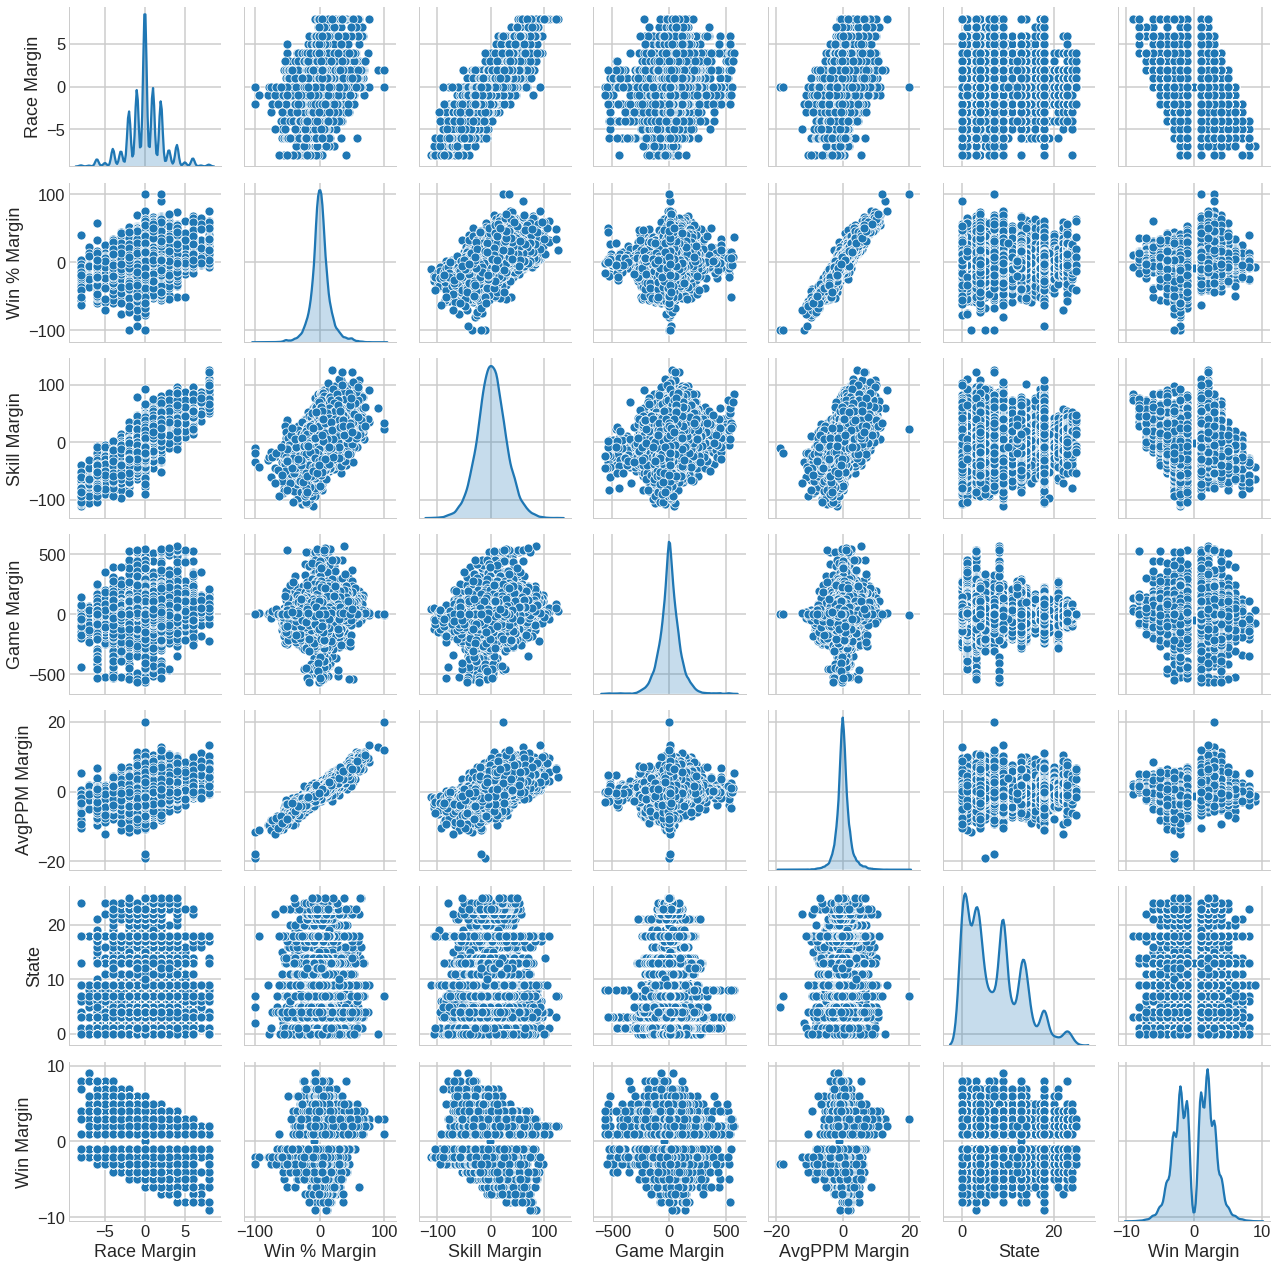

In [4]:
sns.pairplot(df, palette='flare', diag_kind='kde');

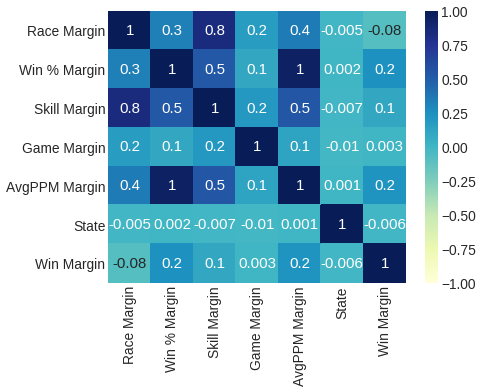

In [5]:
plt.figure(figsize=(8,6),dpi=60)
heatmap = sns.heatmap(df.corr(method='pearson'), fmt='.1g',cmap='YlGnBu', vmin=-1, vmax=1, annot=True)

__Comments__: There is an almost perfect correlation between Win % Margin and AvgPPM Margin, suggesting that these features lack independence (this is likely to be true in reality). High correlations are also seen between Race Margin and Skill Margin, and Win % Margin/AvgPPM Margin and Skill Margin. The former relationship is not a perfect dependence due to the inconsistent NAPA rules, as described earlier. The latter relationship makes conceptual sense, as higher ranked players are more likely to win games than lower ranked players. However, importantly, there are only weak correlations between the independent variables and the target variable, Win Margin. This implies that there will be a high degree of variability in a predictive model, due to the randomizing influence of the handicap system.

## Linear Regression <a id='linear'></a>

Linear regression is a suitable model for this situation, due the independent variables being distributed approximately normally, and the target variable being quasi-continuous. No obvious nonlinear relationships were observed in the correlation plot above.

The base model is first scaled and then fit using all available features. The metrics for model performance will be the mean absolute error (MAE) and coefficient of correlation (R2) between predictions and true results.

In [6]:
X = df[['Race Margin', 'Win % Margin', 'Skill Margin', 'AvgPPM Margin', 'Game Margin', 'State']]
y = df['Win Margin']

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

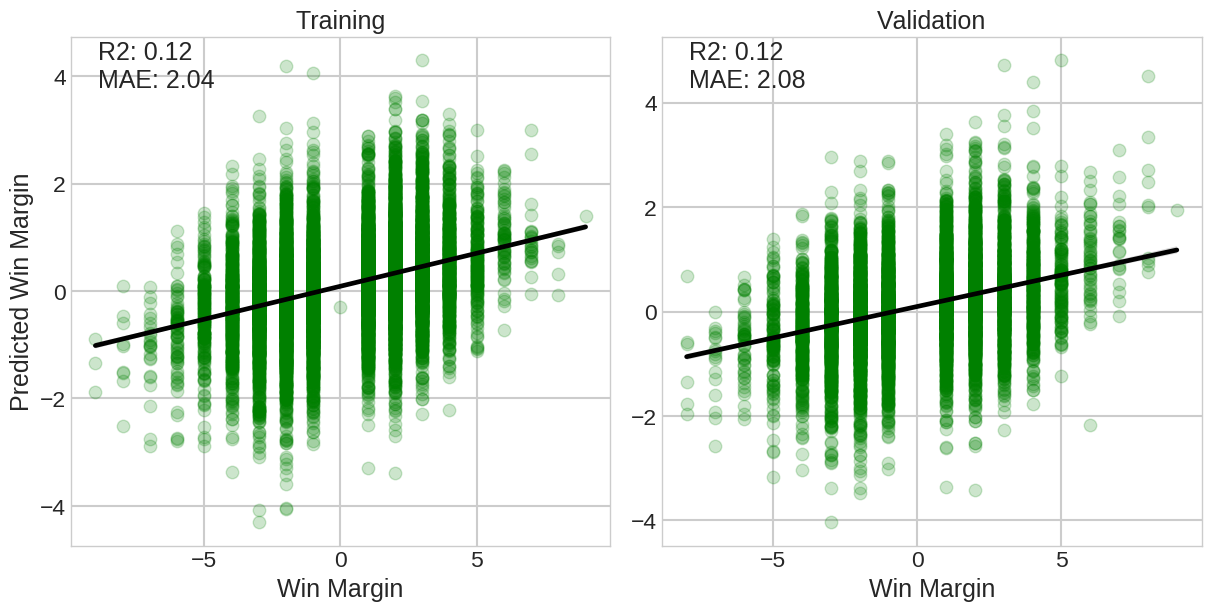

In [8]:
def lin_reg_plot(X,y,ax):
    ''' Create a pipeline to fit and visualize a scaled linear regression model.'''
    
    pipe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.6, test_size=0.4, random_state = 0)
    lr_mod = pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_val_pred = pipe.predict(X_val)
    
    fig, ax = plt.subplots(1,2,figsize=(12,6), dpi=100, constrained_layout=True)
    sns.regplot(y_train, y_train_pred, color='green', scatter_kws={'alpha': 0.2}, line_kws = {'color':'black'}, ax=ax[0])
    r2 = lr_mod.score(X_train, y_train)
    mae = mean_absolute_error(y_train, y_train_pred)
    ax[0].annotate("R2: %.2f \nMAE: %.2f"%(r2, mae), xy=(0.05, 0.90), xycoords='axes fraction')
    ax[0].set_title('Training')
    ax[0].set_ylabel('Predicted Win Margin')
    
    sns.regplot(y_val, y_val_pred, color='green', scatter_kws={'alpha': 0.2}, line_kws = {'color':'black'}, ax=ax[1])
    r2 = lr_mod.score(X_val, y_val)
    mae = mean_absolute_error(y_val, y_val_pred)
    ax[1].annotate("R2: %.2f \nMAE: %.2f"%(r2, mae), xy=(0.05, 0.90), xycoords='axes fraction')
    ax[1].set_title('Validation')

lin_reg_plot(X, y, ax)

__Comments__: As expected, the weak correlations observed between the independent variables and the target feature lead to predictions with high variability. The model is underfitting the data, as seen by the similar performance in the training and validation sets. Performance could be improved by collecting more data, or identifying new features which explain more variance in result win margins.

In [9]:
def lin_reg(X,y):
    ''' Fit a linear regression model (no visualization).'''
    
    pipe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 0)
    lr_mod = pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_val_pred = pipe.predict(X_val)

    r2 = lr_mod.score(X_val, y_val)
    mae = mean_absolute_error(y_val, y_val_pred)
    
    return r2, mae, lr_mod, y_val, y_val_pred, y_train, y_train_pred

## Feature selection

As we have already seen, some features are mutually dependent or strongly correlate with one another. The least explanatory features can be indentified by performing a grid search over all feature combinations and selecting the fewest number of features which yield the lowest MAE/ highest R2.

In [10]:
from itertools import permutations

all_perms = []
all_r2s = []
all_maes = []
arr = np.zeros(len(X.columns)) # this will store the number of features in each iteration

for i in range(0, len(arr)):
    arr = arr.copy()
    arr[i] = 1
    perms = list(set((permutations(arr)))) # all permutations for the selected number of features
    all_perms.append(perms) # all permutations over all numbers of features
    
    r2s = []
    maes = []
    
    for perm in perms:
        sub = X.columns[np.array(perm)!=0] # get the list of features for this permutation
        r2, mae, _, _, _, _, _ = lin_reg(X[sub], y) # get the metrics for this permutation
        r2s.append(r2)
        maes.append(mae)
    
    all_r2s.append(r2s)
    all_maes.append(maes)

In [11]:
print([max(arr) for arr in all_r2s])
print([min(arr) for arr in all_maes])

[0.0564492470663972, 0.10266171438898664, 0.12577125691494928, 0.12616686304776703, 0.1261941281523854, 0.12599641059095312]
[2.1632291250167386, 2.1395817550384804, 2.0977753808651176, 2.0975371854429907, 2.0976248227138568, 2.097911395532906]


__Comments__: The lowest MAE and 2nd highest R2 were observed when using 4 features. Using 3 features results in a marginal reduction in performance, but for now 4 will be used. 

## Linear regression with optimal features <a id='scatter'></a>

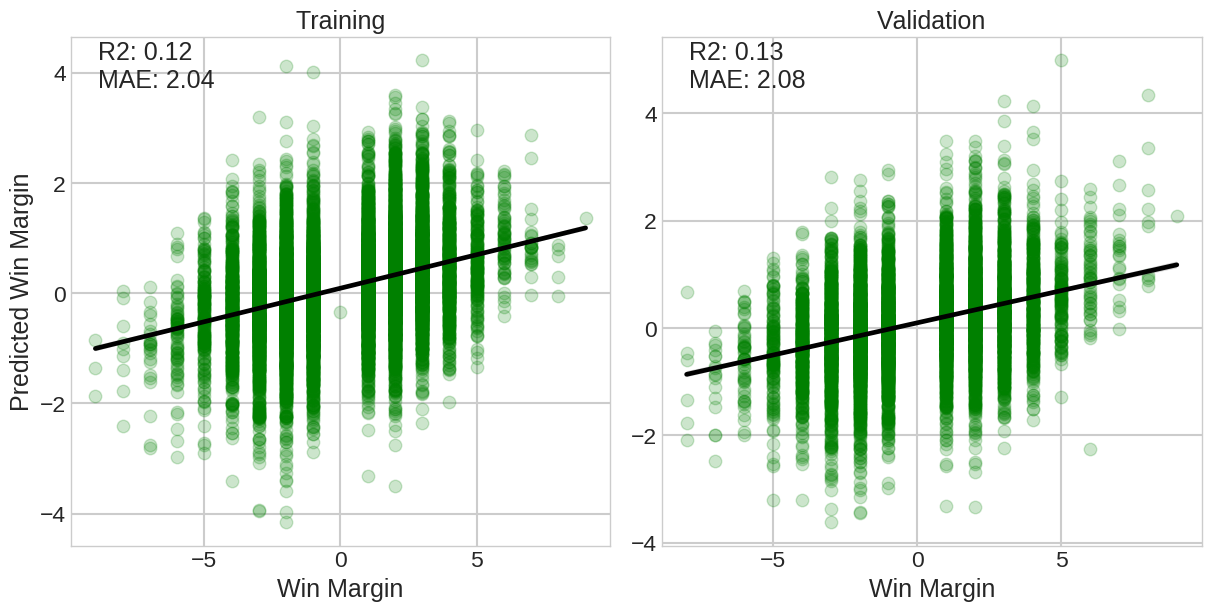

In [12]:
best_perm = all_perms[3][all_maes[3].index(min(all_maes[3]))]
subset = X.columns[np.array(best_perm)!=0]

lin_reg_plot(df[subset], y, ax)

__Comments__: Since the model barely shows any change, this confirms that the dropped features were redundant. However, the model still shows high variation in its predictions.

## Model uncertainty

Bootstrapping can be used to determine confidence intervals of the linear regression coefficients. This is one method to quantify the uncertainty in the model. In each trial, data points are randomly selected with replacement, resulting in a subset of the original data being used to fit the model. The variation in the model coefficients can be visualized over all trials with a boxplot. 

In [13]:
from sklearn.utils import resample

n_bootstraps = 1000

coeffs = []

for _ in range(n_bootstraps):
    sample_X, sample_y = resample(df[subset], y)
    r2, mae, lr_mod, _, _, _, _ = lin_reg(sample_X, sample_y)
    coeffs.append(lr_mod.get_params()['lr'].coef_)
    
errors = pd.DataFrame(coeffs, columns = subset)

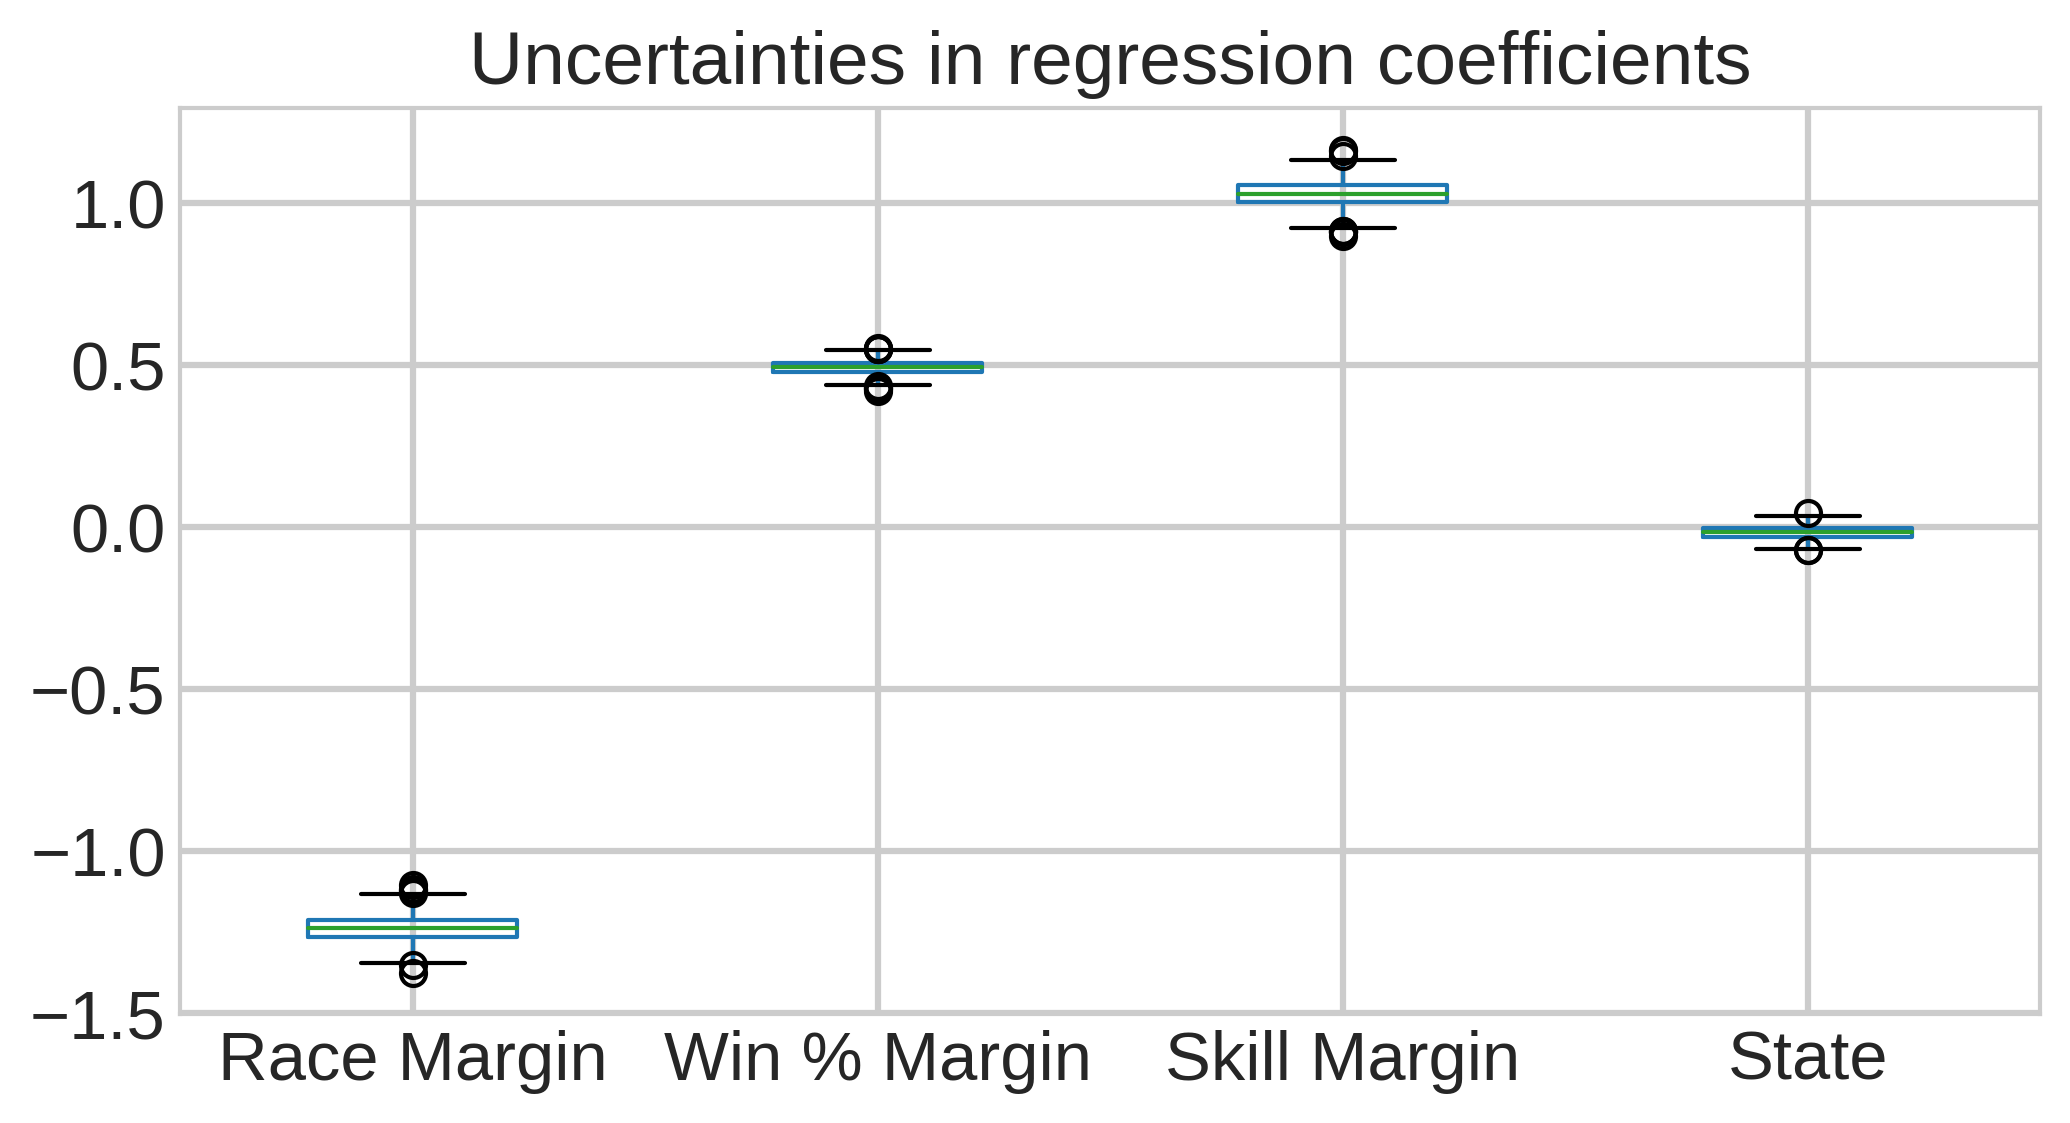

In [14]:
fig, ax = plt.subplots(figsize=(8,4), dpi=300)
errors.plot(kind='box', ax=ax)
plt.title('Uncertainties in regression coefficients');

__Comments__: It is immediately obvious that the State feature has a very small impact on the model predictions compared to the others. The Race Margin and Skill Margin features are closely related, and this is reflected by having almost equal magnitudes with opposite signs and thus almost cancelling each other out. However, the small inconsistences in NAPA race calculations contribute to some explanation of variance. Not surprisingly, the Win % Margin feature has the narrowest confidence intervals, which makes sense given that it also had the highest coefficient of correlation with the target variable.

## Logit model for winning probability <a id='log'></a>

The linear regression model produces point estimates for the winning margin for a given player over another player. This is not actually very useful within the context of a real match, since these predictions vary a great deal and we are not really sure if we can trust the value outputted by the model.  
What would be much more informative is for the team captain to have an estimate of the __probability__ that a match will be won by a given player.

One method to extract this from the current model is to look at the distribution of actual results when the model predicts a winning margin within a certain range. We can achieve this by binning the data points in the [linear regression scatter plot](#scatter) by actual win margin for a given interval of predicted winning margin. In NAPA rules, aside from special circumstances, 14 points are awarded for a win regardless of the winning margin. Therefore, it is sufficient to only record the fraction of actual matches within that interval that ended in a win for player A. Then, we can train a conversion model using the winning margin v winning fraction data and apply it to predict winning probability. Since the winning fraction/probability must lie between 0 and 1, a logit model seems like a suitable choice. 

In [17]:
r2, mae, lr_mod, y_val, y_val_pred, y_train, y_train_pred = lin_reg(df[subset], y)

In [16]:
def get_fract_wins(gran, lower, upper, y, y_pred):
    ''' For predicted results within a narrow interval (width defined by granularity, gran),
    return the fraction of actual results which were a win for player A.'''
    
    steps = np.arange(lower, upper, gran)
    fract = np.zeros(len(steps))
    
    for i in range(1, len(steps)):
        interval = y[(y_pred>steps[i-1]) & (y_pred<steps[i])]
        if len(interval) > 0:
            fract[i] = len(interval[interval>0])/len(interval)
        else:
            fract[i] = np.nan
            
    return steps, fract

## Fitting the probability conversion model

1. Using the training data, find the fraction of wins by player A for increasing winning margin (calculate the fraction over interval widths of 0.1 win margin units).
2. Since sklearn does not support logistic regression on a continuous variable, apply a logit transform to the fraction data and fit a linear regression model.
3. Validate the conversion model using the calculated true win fractions of the validation data. 

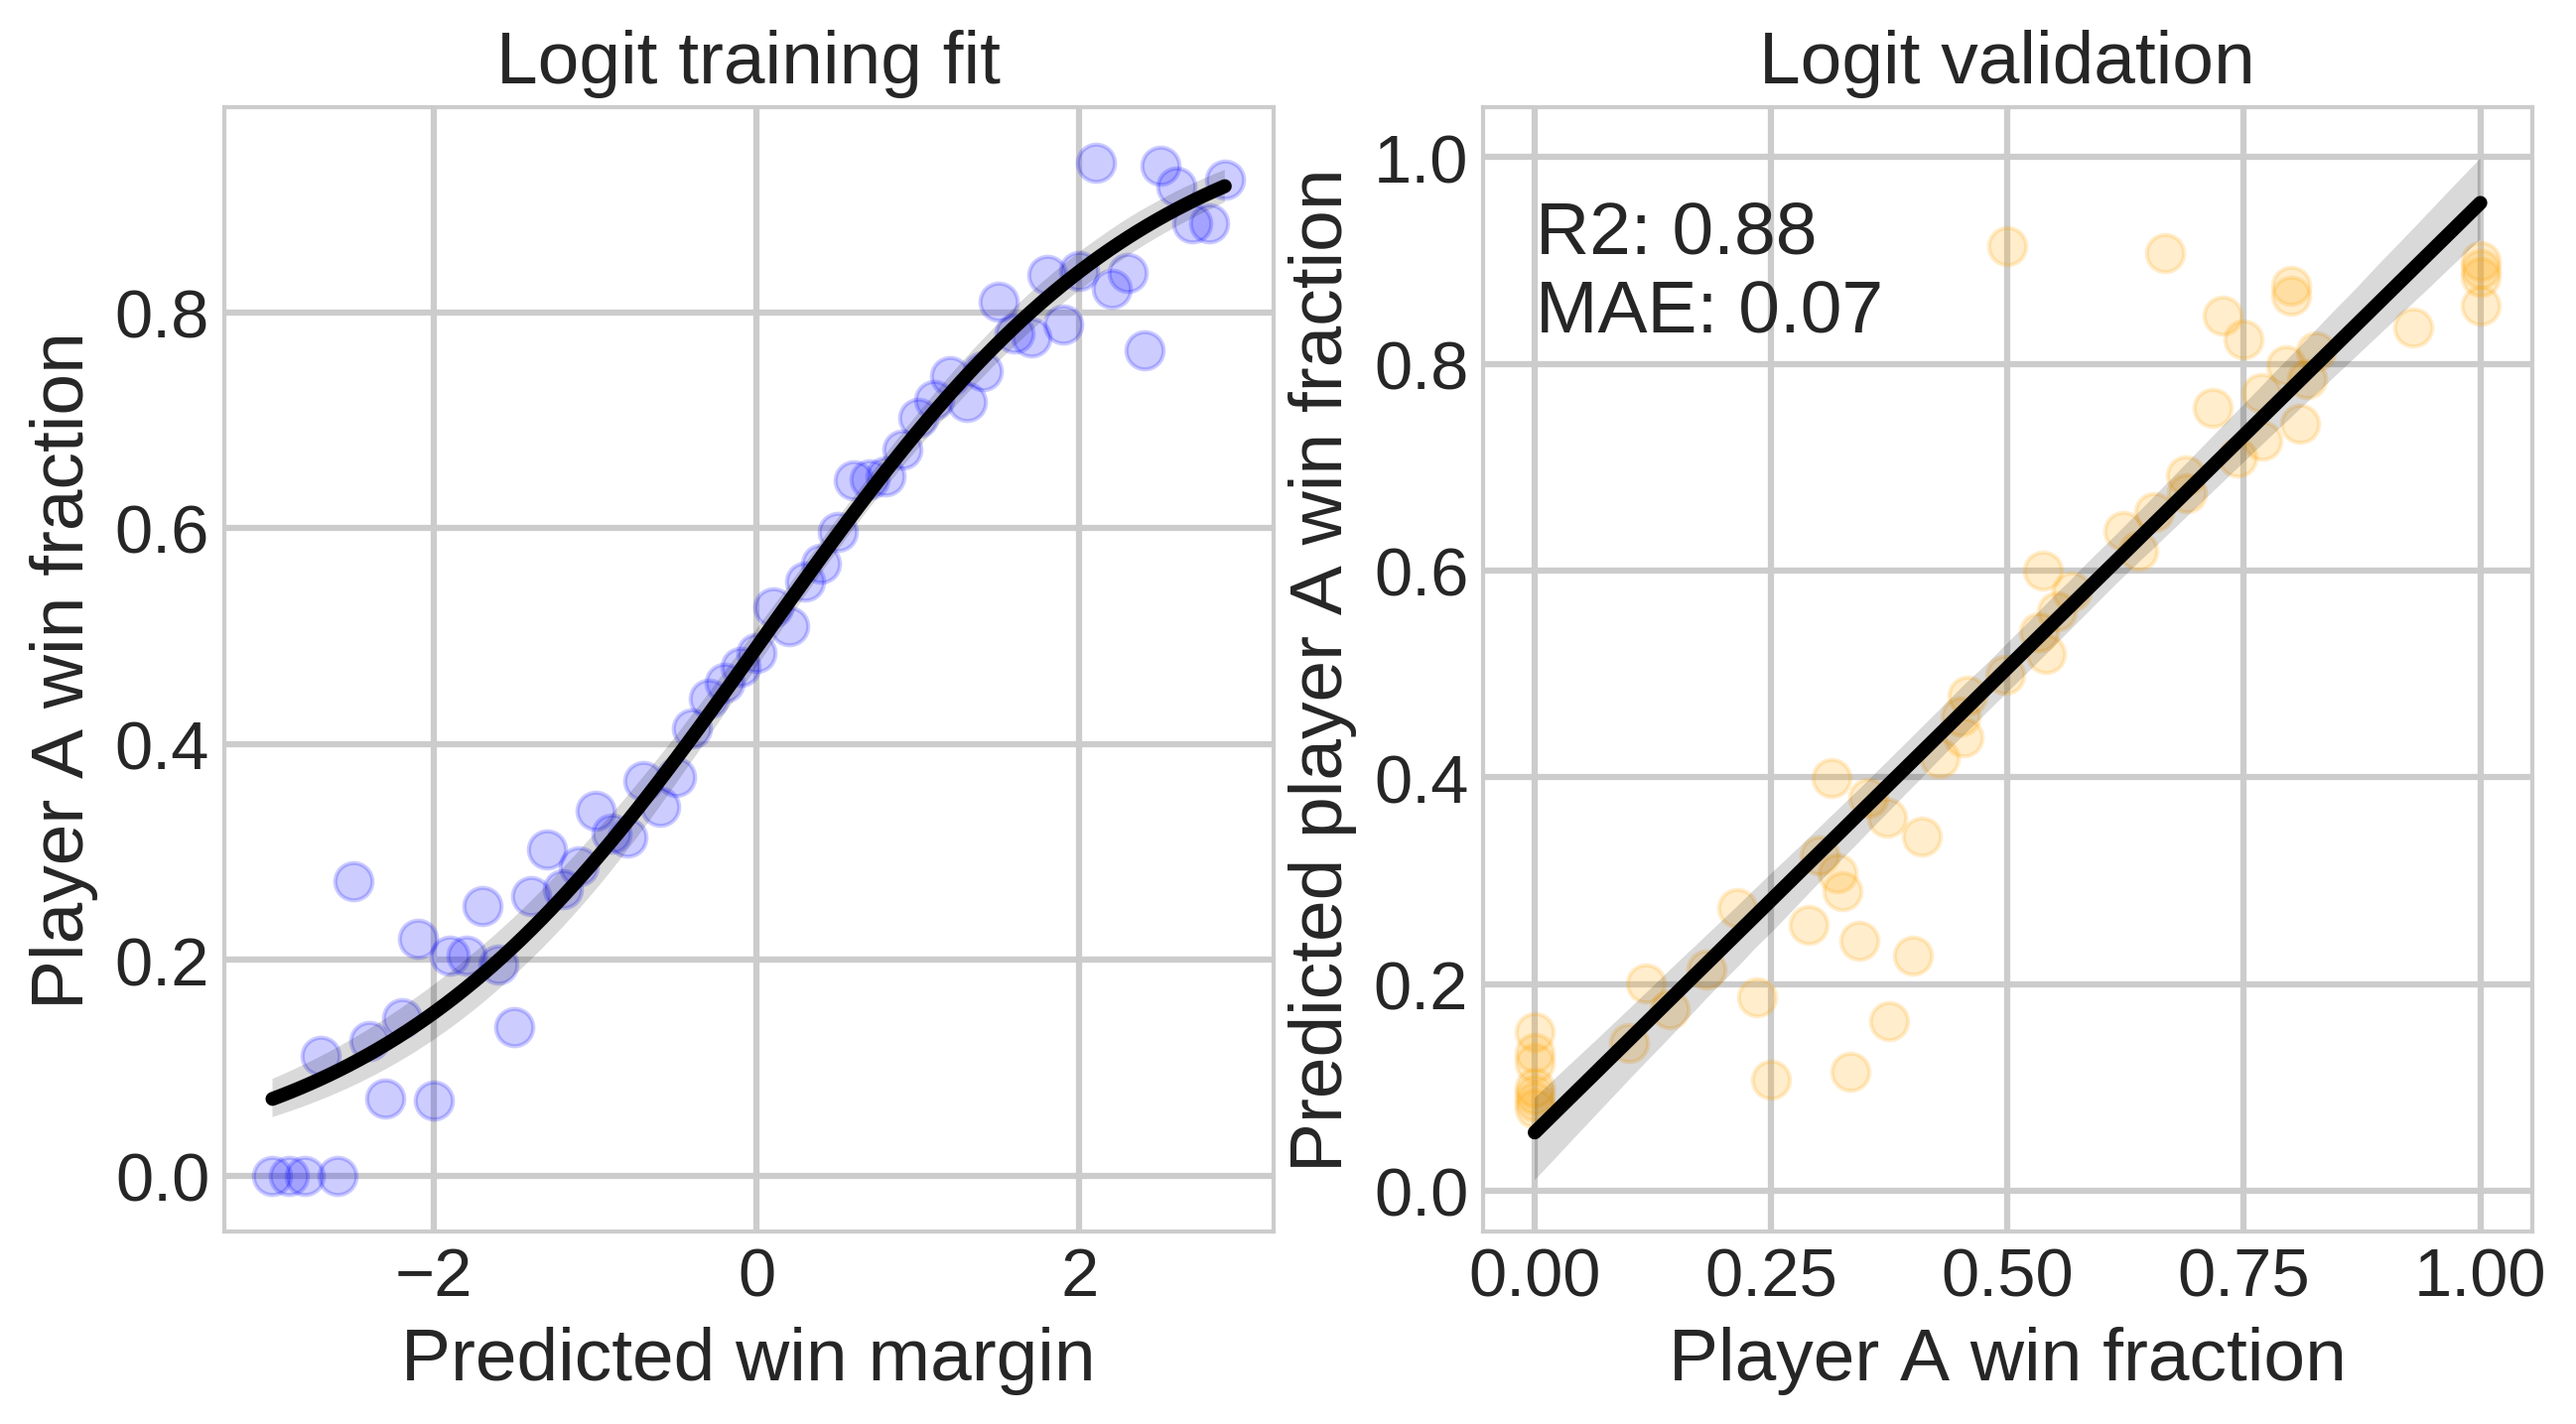

In [81]:
from scipy.special import logit, expit
from sklearn.metrics import r2_score

# retrieve win fractions v win margin for the training data
steps_train, fract_train = get_fract_wins(0.1, -3, 3, y_train, y_train_pred)

# visualize a logisitic fit
fig, ax = plt.subplots(1,2, figsize=(10,5), dpi=300)
sns.regplot(steps_train, fract_train, color='blue', logistic=True, scatter_kws={'alpha': 0.2}, line_kws = {'color':'black'}, ax=ax[0])
ax[0].set_title('Logit training fit')
ax[0].set_xlabel('Predicted win margin')
ax[0].set_ylabel('Player A win fraction');

# transform training data to enable a linear model to be fit
logit_fract = logit(fract_train)
log_df = pd.DataFrame({'Predicted':steps_train, 'log_fract':logit_fract})
log_df.replace([np.inf, -np.inf], np.nan, inplace=True)
log_df.dropna(inplace=True)

# fit the linear model to the transformed data
lr_fract_mod = LinearRegression().fit(log_df['Predicted'].values.reshape(-1,1),
                                      log_df['log_fract'])

# retrieve win fractions v win margin for the validation data
steps_val, fract_val = get_fract_wins(0.1, -3, 3, y_val, y_val_pred)

# predict win fractions for the validation data and inverse transform
fract_val_pred = expit(lr_fract_mod.predict(steps_val.reshape(-1,1)))

# compare predicted win fractions to actual win fractions 
sns.regplot(fract_val, fract_val_pred, color='orange', scatter_kws={'alpha': 0.2}, line_kws = {'color':'black'}, ax=ax[1])
r2 = r2_score(fract_val, fract_val_pred)
mae = mean_absolute_error(fract_val, fract_val_pred)
ax[1].annotate("R2: %.2f \nMAE: %.2f"%(r2, mae), xy=(0.05, 0.80), xycoords='axes fraction')
ax[1].set_title('Logit validation')
ax[1].set_xlabel('Player A win fraction')
ax[1].set_ylabel('Predicted player A win fraction');

## Finding the optimum granularity over which to calculate the win fractions

* Fit the linear/logit model for increasing bin widths between 0.1 and 1 win margin units. 
* Look for bin width which minimizes noise in the predicted win fractions (smallest mean absolute error). 

In [82]:
grans = np.arange(0.1, 1, 0.05)
r2s = []
maes = []

for g in grans:
    steps_train, fract_train = get_fract_wins(g, -3, 3, y_train, y_train_pred)
    logit_fract = logit(fract_train)
    log_df = pd.DataFrame({'Predicted':steps_train, 'log_fract':logit_fract})
    log_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    log_df.dropna(inplace=True)
    lr_fract_mod = LinearRegression().fit(log_df['Predicted'].values.reshape(-1,1),
                                      log_df['log_fract'])
    
    steps_val, fract_val = get_fract_wins(g, -3, 3, y_val, y_val_pred)
    fract_val_pred = expit(lr_fract_mod.predict(steps_val.reshape(-1,1)))

    r2s.append(r2_score(fract_val, fract_val_pred))
    maes.append(mean_absolute_error(fract_val, fract_val_pred))

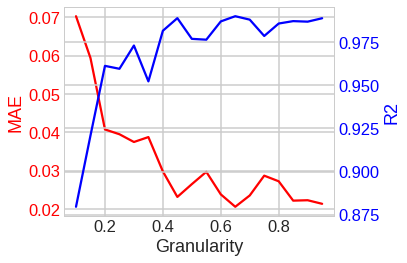

In [84]:
fig, ax1 = plt.subplots()

color = 'red'
ax1.set_xlabel('Granularity')
ax1.set_ylabel('MAE', color=color)
ax1.plot(grans, maes, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel('R2', color=color)
ax2.plot(grans, r2s, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

__Comments__: MAE and R2 stabilize at a bin width of about 0.45 win margin units. Fit the model again with this value used as the granularity.

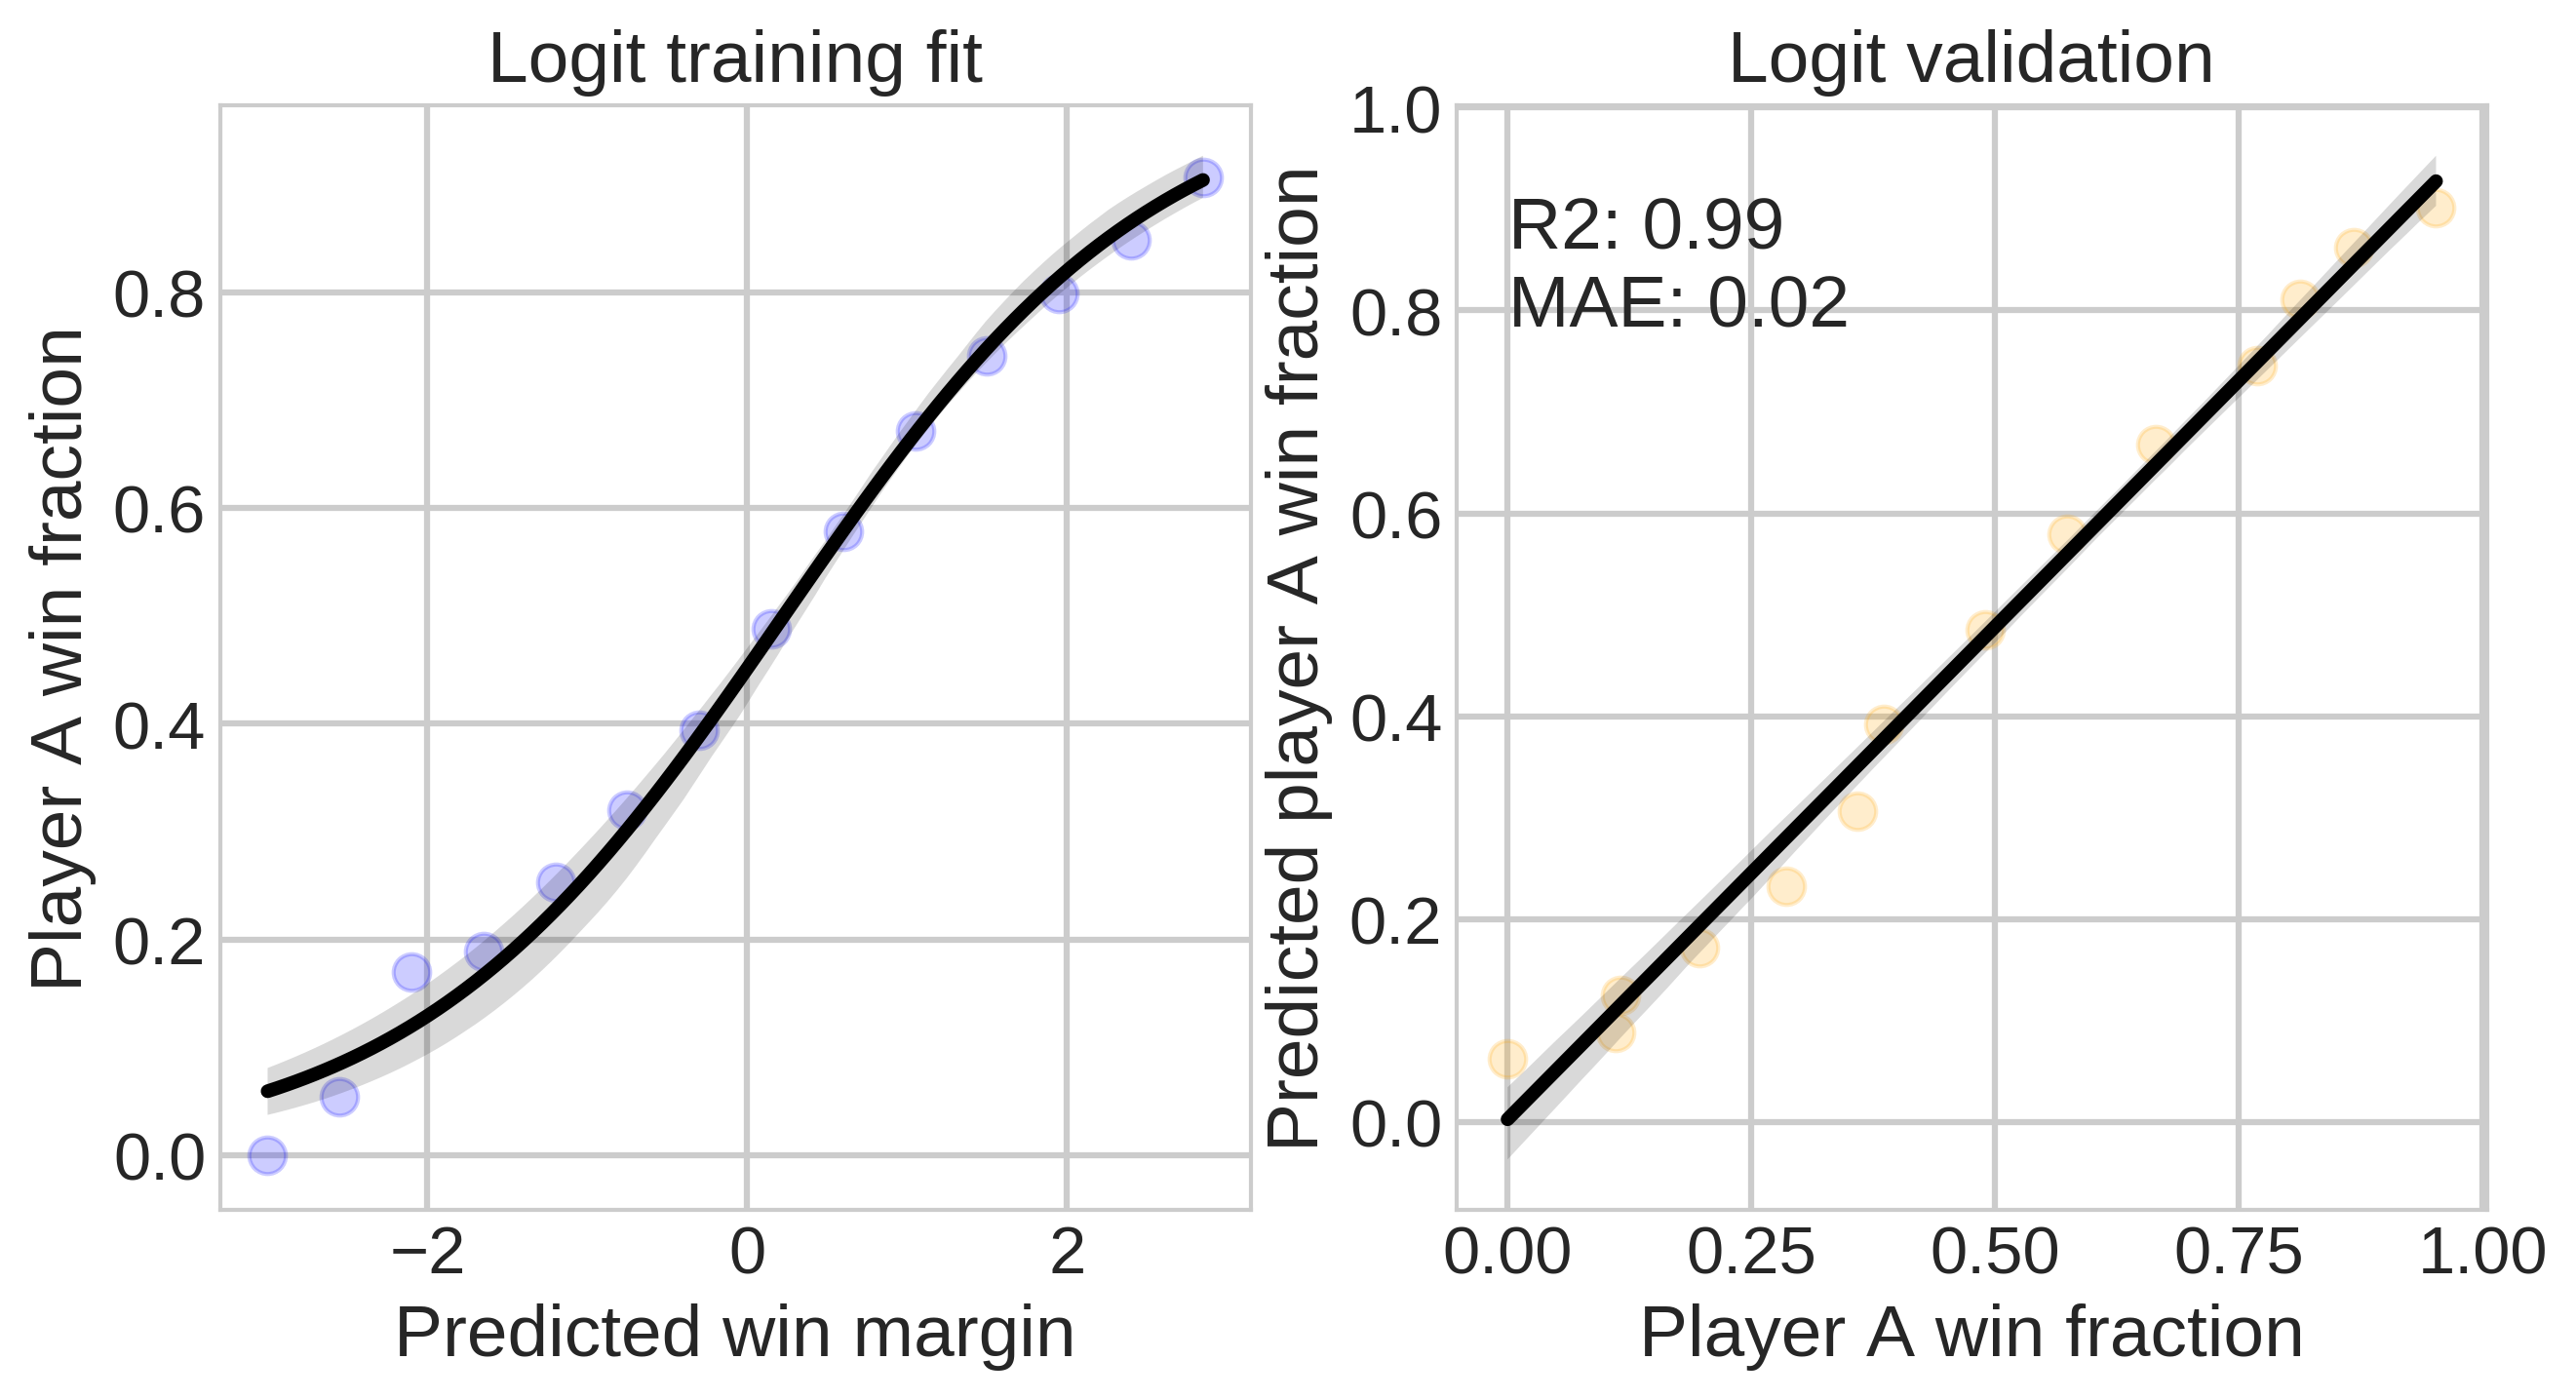

In [85]:
# retrieve win fractions v win margin for the training data
steps_train, fract_train = get_fract_wins(0.45, -3, 3, y_train, y_train_pred)

# visualize a logisitic fit
fig, ax = plt.subplots(1,2, figsize=(10,5), dpi=300)
sns.regplot(steps_train, fract_train, color='blue', logistic=True, scatter_kws={'alpha': 0.2}, line_kws = {'color':'black'}, ax=ax[0])
ax[0].set_title('Logit training fit')
ax[0].set_xlabel('Predicted win margin')
ax[0].set_ylabel('Player A win fraction');

# transform training data to enable a linear model to be fit
logit_fract = logit(fract_train)
log_df = pd.DataFrame({'Predicted':steps_train, 'log_fract':logit_fract})
log_df.replace([np.inf, -np.inf], np.nan, inplace=True)
log_df.dropna(inplace=True)

# fit the linear model to the transformed data
lr_fract_mod = LinearRegression().fit(log_df['Predicted'].values.reshape(-1,1),
                                      log_df['log_fract'])

# retrieve win fractions v win margin for the validation data
steps_val, fract_val = get_fract_wins(0.45, -3, 3, y_val, y_val_pred)

# predict win fractions for the validation data and inverse transform
fract_val_pred = expit(lr_fract_mod.predict(steps_val.reshape(-1,1)))

# compare predicted win fractions to actual win fractions 
sns.regplot(fract_val, fract_val_pred, color='orange', scatter_kws={'alpha': 0.2}, line_kws = {'color':'black'}, ax=ax[1])
r2 = r2_score(fract_val, fract_val_pred)
mae = mean_absolute_error(fract_val, fract_val_pred)
ax[1].annotate("R2: %.2f \nMAE: %.2f"%(r2, mae), xy=(0.05, 0.80), xycoords='axes fraction')
ax[1].set_title('Logit validation')
ax[1].set_xlabel('Player A win fraction')
ax[1].set_ylabel('Predicted player A win fraction');

__Comments__: The logit model performs very well! A mean absolute error of 0.02 indicates that with the exception of very close matches, the player with the highest chance of victory can be correctly identified. This will enable team captains to make informed decisions about which players they select for each match.

## Summary

Pool match data is very noisy! There is inherent randomness due to the environment in which matches take place (alas, there were no data available on units of alcohol consumed per player). Furthermore, the NAPA handicap system certainly goes a long way towards balancing the odds between two players of mismatched skill level. Therefore, the data available here were insufficient to develop a model which can accurately predict the exact final score in a given match. Fortunately, this is not a problem for the average team captain, as it is already a fantastically useful insight to have access to the match winning probability for their player against a player on the opposing team. This was provided by a logit fit to the true player A win fractions, binned by the predicted win margins from the linear regression model. 

## Directions for improvement

Since significant value could be extracted from a simple linear + logit regression, it was not immediately necessary to pursue more complex machine learning models. Due to the noisy nature of the data, it unlikely that such models would perform better in terms of the chosen metrics of mean absolute error and R2 value. On the other hand, it might be useful to test a more flexible generalized linear model in order to identify possible interactions between features. A gradient-boosted forest model such as xgboost could perform slightly better, however this would lead to a compromize in interpretability.  

In [32]:
import pickle

pickle.dump(lr_mod, open( "lr.pkl", "wb" ))
pickle.dump(lr_fract_mod, open( "lr_prob.pkl", "wb" ))